In [1]:
from agents import DPM_Agent, agent_loss, sampled_agent_reward
from trading_env.environment import TradingEnv

import random
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

## Construct Synthetic data

In [2]:
data_length = 100
NOISE = 3

r = np.logspace( -4, -2, 4)

rates = np.concatenate((-r,r),axis = 0)

time_array = np.linspace(0,data_length-1,data_length)

rates_v_time =  np.outer(rates,time_array) + NOISE * np.outer(rates, np.sin(time_array))

data = np.exp(np.stack([rates_v_time,rates_v_time],axis = 2))

data.shape

(8, 100, 2)

### Synthetic data visualization

We have constructed 8 oscilating exponential series. The agent should learn to differentiate between these series and invest in the series offering the highest reward.

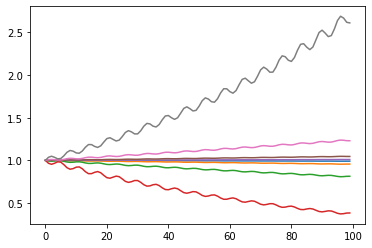

In [3]:
for k in range(8):
    plt.plot(data[k,:,0])
plt.show()

In [4]:
agent = DPM_Agent()
env = TradingEnv(data)

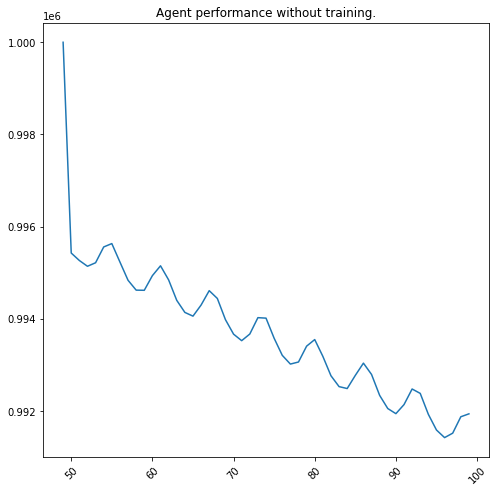

Initial value of portfolio:  1000000.0
Final value of portfolio:  991936.3
Maximum value of portfolio:  1000000.0
Minimum value of portfolio:  991420.3


In [5]:
# Simulate untrained agent to view baseline
loss = agent_loss(env,agent)
plt.figure(figsize=(8,8))
plt.plot(time_array[49:], env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title('Agent performance without training.')
plt.show()
portfolio_vals = env.portfolio_value_hist
print('Initial value of portfolio: ',portfolio_vals[0].numpy())
print('Final value of portfolio: ', portfolio_vals[-1].numpy())
print('Maximum value of portfolio: ',max(portfolio_vals).numpy())
print('Minimum value of portfolio: ',min(portfolio_vals).numpy())

In [6]:
TRADING_DAYS_PER_YEAR = 253

#@tf.function
def train_step(agent,batch):
    """Runs a model training step."""
    env = TradingEnv(batch,train_noise=0.2)
 
    with tf.GradientTape() as tape:
        tape.watch(agent.model.trainable_variables)
        loss = agent_loss(env,agent,dsct = 0.99)

        grad = tape.gradient(loss,agent.model.trainable_variables)
        grad = [g / tf.reduce_mean(tf.abs(g)) for g in grad]
        agent.opt.apply_gradients(zip(grad,agent.model.trainable_variables))

    reward = -TRADING_DAYS_PER_YEAR * loss/(env._end_tick-env._start_tick)

    return reward

In [7]:
def Callback_EarlyStopping(RewardsList, min_delta=0, patience=30):
    
    if RewardsList[-1] != RewardsList[-1]:
        print('NAN error')
        return True   


    #No early stopping for 3*patience epochs 
    if len(RewardsList)//patience < 3 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(RewardsList[::-1][2*patience:3*patience]) #third-last
    mean_recent = np.mean(RewardsList[::-1][:patience]) #last
    #you can use relative or absolute change
    delta = mean_recent - mean_previous # change
    percent_delta = delta / mean_previous  # relative change
    if percent_delta < min_delta : 
        print(f"*CB_ES* Percent change in reward value: {percent_delta*1e2:.4f}")
        return True 
    else:
        return False

In [8]:
train_rewards = [] 
MAX_EPOCHS = 100 
for epoch in range(MAX_EPOCHS):

    reward = train_step(agent,data)
        
    
    train_rewards.append(reward)


    if Callback_EarlyStopping(train_rewards):
        break

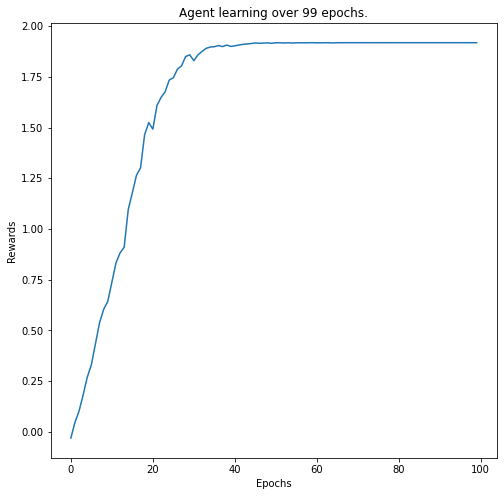

In [9]:
plt.figure(figsize=(8,8))
plt.plot(train_rewards) 
plt.title(f'Agent learning over {epoch} epochs.')
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.show()

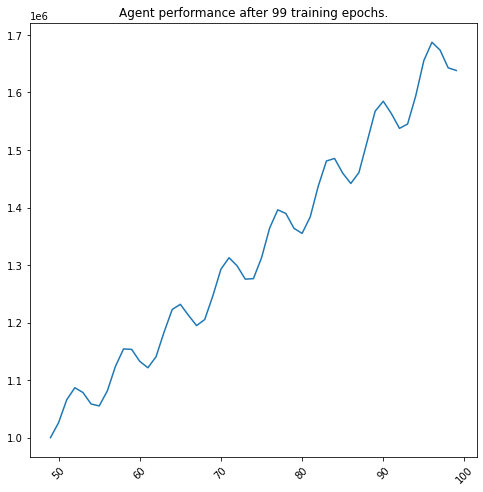

Initial value of portfolio:  1000000.0
Final value of portfolio:  1638241.9
Maximum value of portfolio:  1687262.5
Minimum value of portfolio:  1000000.0


In [10]:
# Simulate trained agent to view behavior after training
loss = agent_loss(env,agent)
plt.figure(figsize=(8,8))
plt.plot(time_array[49:], env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title(f'Agent performance after {epoch} training epochs.')
plt.show()
print('Initial value of portfolio: ',env.portfolio_value_hist[0].numpy())
print('Final value of portfolio: ',env.portfolio_value_hist[-1].numpy())
print('Maximum value of portfolio: ',max(env.portfolio_value_hist).numpy())
print('Minimum value of portfolio: ',min(env.portfolio_value_hist).numpy())

### The agent traded on 50 days of data and earned a 63% return.
### This is the maximum possible return, demonstrating the agent is capable of learning correctly on well behaved data.